##### Babaahmadi-narges
### Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk import word_tokenize
# from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns


### Reading the datasets

In [2]:
Sanders = pd.read_csv("SandersPosNeg.csv", header=None, sep="\t")
Sanders.rename(columns={0: "label", 1: "tweet"}, inplace=True)
Sanders.head()

,label,tweet
0,0,RT @cjwallace03: So apparently @apple put MB c...
1,0,RT @Jewelz2611 @mashable @apple iphones r 2 ex...
2,0,@mashable @apple iphones r 2 expensive. Most w...
3,0,THiS IS WHAT WiLL KiLL APPLE http://t.co/72Jw4...
4,4,Now all @Apple has to do is get swype on the i...


In [3]:
OMD = pd.read_csv("OMD.csv", header=None, sep="\t",encoding='mac_roman')
OMD.rename(columns={0: "tweet",}, inplace=True)
OMD.head()

,tweet
0,"0,Watching by myself #tweetdebate Not drinkin..."
1,"0,@ahg3 @MichDot Yeah, slime was actually my s..."
2,"0,Preparing to have a heart attack #tweetdebate,"
3,"0,no debate moderators under 50, sorry #tweet..."
4,"0,@current Now staring at black screen on http..."


In the OMD dataset, Labels are merged with tweets, so in Label function I extract labels.

In [4]:
def label(tweet) :
    m = tweet.find(',')
    return int(tweet[:m])

In [5]:
OMD['label'] = OMD['tweet'].apply(lambda X: label(X))
OMD.head()

,tweet,label
0,"0,Watching by myself #tweetdebate Not drinkin...",0
1,"0,@ahg3 @MichDot Yeah, slime was actually my s...",0
2,"0,Preparing to have a heart attack #tweetdebate,",0
3,"0,no debate moderators under 50, sorry #tweet...",0
4,"0,@current Now staring at black screen on http...",0


### Sentiment Disctribution

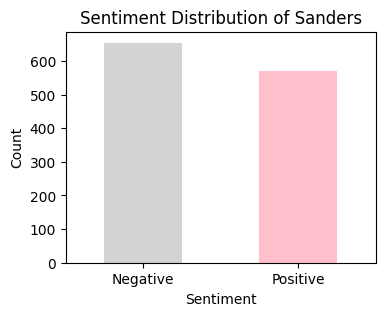

In [6]:
# Cell 10: Visualization - Sentiment Distribution
sentiment_distribution = Sanders['label'].value_counts()
sentiment_distribution.index = ['Negative', 'Positive']  # Replace 0 with 'Negative' and 4 with 'Positive'
plt.figure(figsize=(4, 3))
sentiment_distribution.plot(kind='bar', color=['#D3D3D3', '#FFC0CB'])
plt.title('Sentiment Distribution of Sanders')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


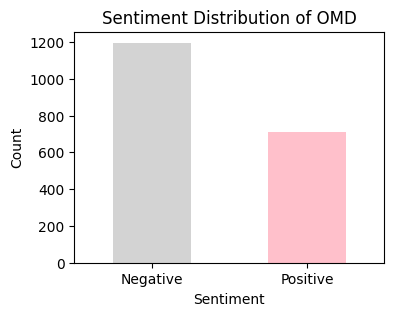

In [7]:
# Cell 10: Visualization - Sentiment Distribution
sentiment_distribution = OMD['label'].value_counts()
sentiment_distribution.index = ['Negative', 'Positive']  # Replace 0 with 'Negative' and 4 with 'Positive'
plt.figure(figsize=(4, 3))
sentiment_distribution.plot(kind='bar', color=['#D3D3D3', '#FFC0CB'])
plt.title('Sentiment Distribution of OMD')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [8]:
def wordcloud_draw(data, color='black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    return wordcloud

def plot_wordclouds(dataset, positive_label, negative_label):
    train_pos = dataset[dataset['label'] == positive_label]
    train_pos = train_pos['tweet']
    train_neg = dataset[dataset['label'] == negative_label]
    train_neg = train_neg['tweet']

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot positive word cloud
    axes[0].imshow(wordcloud_draw(train_pos, 'white'), interpolation='bilinear')
    axes[0].set_title("Positive Words")
    axes[0].axis('off')

    # Plot negative word cloud
    axes[1].imshow(wordcloud_draw(train_neg), interpolation='bilinear')
    axes[1].set_title("Negative Words")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

Sanders Workd Clouds:

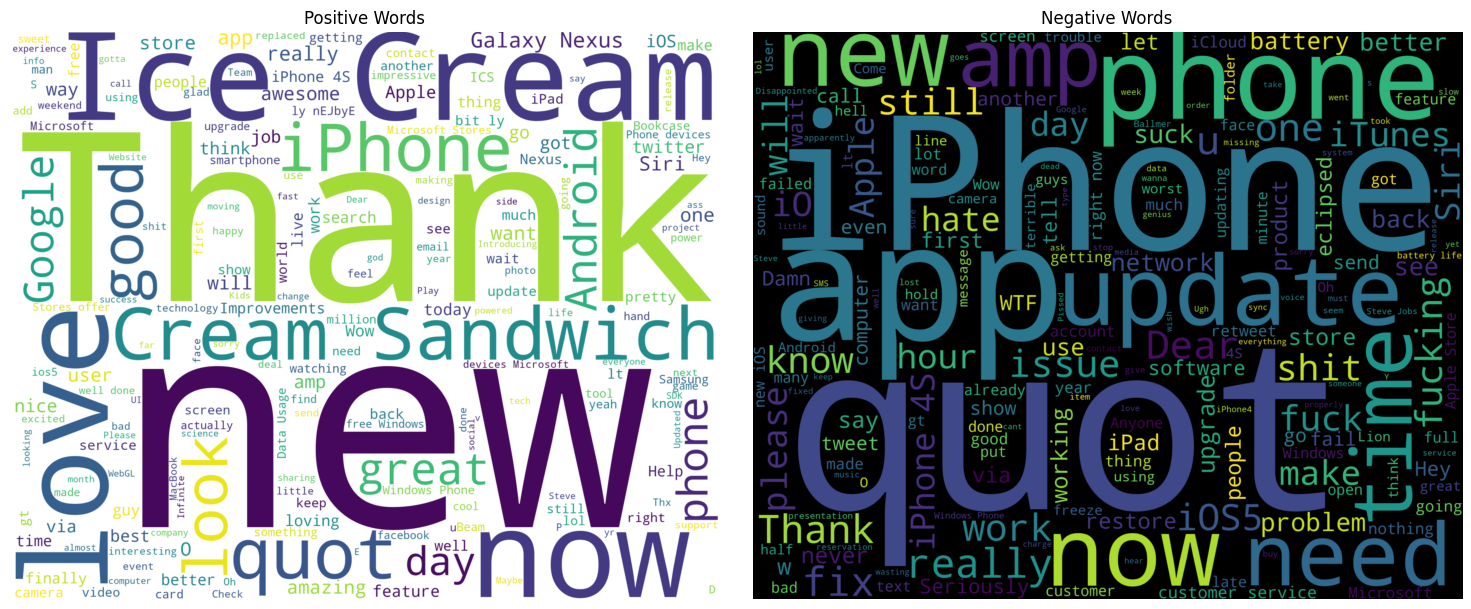

In [9]:
# Plot word clouds for "Sanders" dataset
plot_wordclouds(Sanders, positive_label=4, negative_label=0)

OMD Word Clouds:

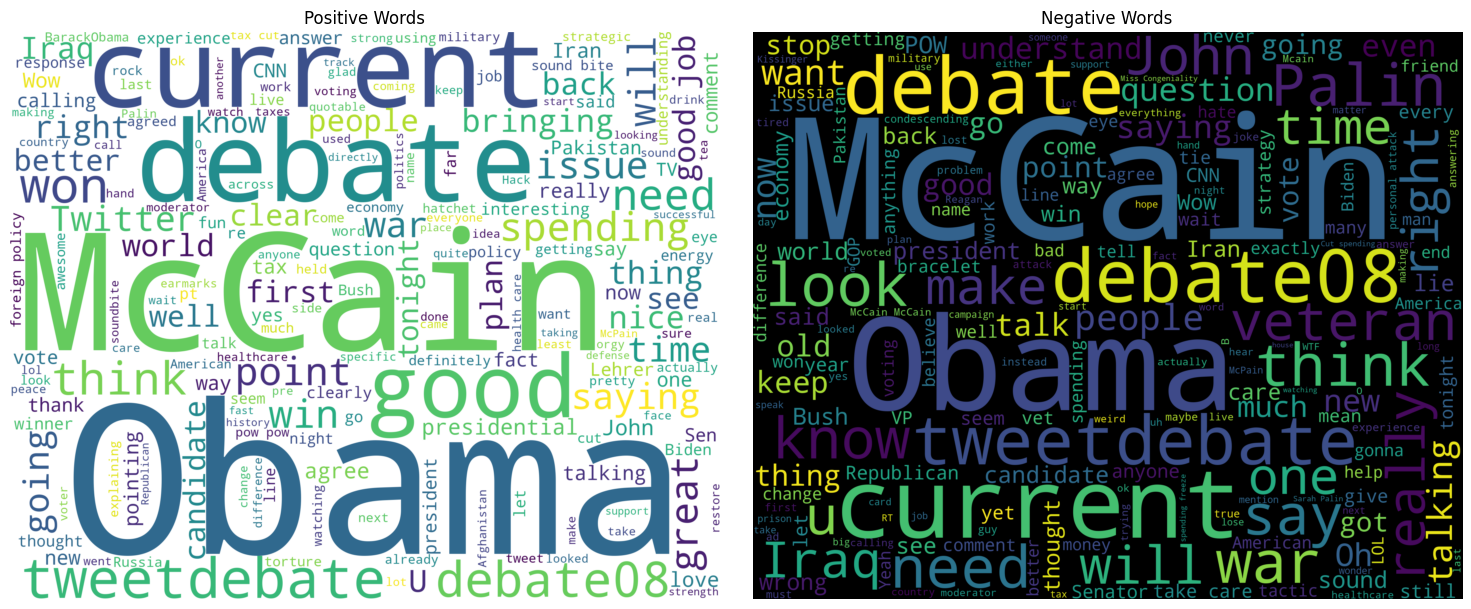

In [10]:
# Plot word clouds for "OMD" dataset
plot_wordclouds(OMD, positive_label=4, negative_label=0)

### preprocessing
Now it's time for cleaning the data.\
The first step is to **remove the punctutions and numbers**.

In [11]:
def punctuation(tweet):
    ret_tweet = ""
    for i in tweet:
        if (i not in string.punctuation) and (i not in "0123456789"):
            ret_tweet+=i
    return ret_tweet

In [12]:
Sanders['tweet']= Sanders['tweet'].apply(punctuation)
Sanders.head()

,label,tweet
0,0,RT cjwallace So apparently apple put MB cap on...
1,0,RT Jewelz mashable apple iphones r expensive ...
2,0,mashable apple iphones r expensive Most went ...
3,0,THiS IS WHAT WiLL KiLL APPLE httptcoJwzc RiP A...
4,4,Now all Apple has to do is get swype on the ip...


In [13]:
OMD['tweet']= OMD['tweet'].apply(punctuation)
OMD.head()

,tweet,label
0,Watching by myself tweetdebate Not drinking ...,0
1,ahg MichDot Yeah slime was actually my second ...,0
2,Preparing to have a heart attack tweetdebate,0
3,no debate moderators under sorry tweetdebate,0
4,current Now staring at black screen on httpwww...,0


The next step is to **convert all letters into lowercase**.\
I do this to avoid counting one word multiple times as different words.

In [14]:
Sanders['tweet']= Sanders['tweet'].apply(lambda x: x.lower())
Sanders.head()

,label,tweet
0,0,rt cjwallace so apparently apple put mb cap on...
1,0,rt jewelz mashable apple iphones r expensive ...
2,0,mashable apple iphones r expensive most went ...
3,0,this is what will kill apple httptcojwzc rip a...
4,4,now all apple has to do is get swype on the ip...


In [15]:
OMD['tweet']= OMD['tweet'].apply(lambda x: x.lower())
OMD.head()

,tweet,label
0,watching by myself tweetdebate not drinking ...,0
1,ahg michdot yeah slime was actually my second ...,0
2,preparing to have a heart attack tweetdebate,0
3,no debate moderators under sorry tweetdebate,0
4,current now staring at black screen on httpwww...,0


**Removing extra whitespace** step:

In [16]:
def whitespace(tweet):
    return  " ".join(tweet.split())

In [17]:
Sanders['tweet']=Sanders['tweet'].apply(whitespace)
Sanders.head()

,label,tweet
0,0,rt cjwallace so apparently apple put mb cap on...
1,0,rt jewelz mashable apple iphones r expensive m...
2,0,mashable apple iphones r expensive most went w...
3,0,this is what will kill apple httptcojwzc rip a...
4,4,now all apple has to do is get swype on the ip...


In [18]:
OMD['tweet']=OMD['tweet'].apply(whitespace)
OMD.head()

,tweet,label
0,watching by myself tweetdebate not drinking wa...,0
1,ahg michdot yeah slime was actually my second ...,0
2,preparing to have a heart attack tweetdebate,0
3,no debate moderators under sorry tweetdebate,0
4,current now staring at black screen on httpwww...,0


The next step is to **tokenize** all tweets:\
Tokenization is the process of splitting text into pieces called tokens.\
I did tokenization using nltk library.

In [19]:
Sanders['tweet']=Sanders['tweet'].apply(lambda X: word_tokenize(X))
Sanders.head()

,label,tweet
0,0,"[rt, cjwallace, so, apparently, apple, put, mb..."
1,0,"[rt, jewelz, mashable, apple, iphones, r, expe..."
2,0,"[mashable, apple, iphones, r, expensive, most,..."
3,0,"[this, is, what, will, kill, apple, httptcojwz..."
4,4,"[now, all, apple, has, to, do, is, get, swype,..."


In [20]:
OMD['tweet']=OMD['tweet'].apply(lambda X: word_tokenize(X))
OMD.head()

,tweet,label
0,"[watching, by, myself, tweetdebate, not, drink...",0
1,"[ahg, michdot, yeah, slime, was, actually, my,...",0
2,"[preparing, to, have, a, heart, attack, tweetd...",0
3,"[no, debate, moderators, under, sorry, tweetde...",0
4,"[current, now, staring, at, black, screen, on,...",0


In [21]:
def plot_token_distribution(data, title):
    # Calculate the number of tokens in each tweet and store them in a list
    text_lens = data['tweet'].apply(len)

    # Calculate the mean number of tokens
    len_mean = text_lens.mean()

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(6, 4))
    axes[0].set_title(f'Distribution of number of tokens in tweets - {title}')

    # Create a boxplot
    sns.boxplot(text_lens, ax=axes[0])

    # Create a histogram
    sns.histplot(text_lens, bins=100, kde=True, ax=axes[1])

    # Adjust the y-axis range for the histogram
    axes[1].set_ylim(0, 200)

    # Add a vertical line for the mean
    axes[1].vlines(len_mean, 0, 200, color='r')

    # Annotate the mean value
    axes[1].annotate("mean", xy=(len_mean, 200), xytext=(len_mean - 2, 205), color='r')

    # Show the plot
    plt.show()


#### Sanders' Tokens Distribution:

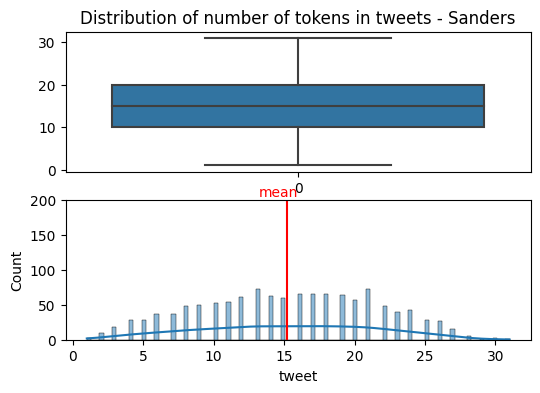

In [22]:
plot_token_distribution(Sanders, 'Sanders')

#### OMD Tokens Distribution:

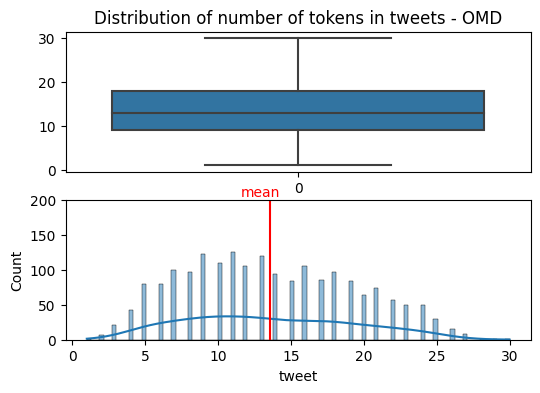

In [23]:
plot_token_distribution(OMD, 'OMD')

One important step in preprocessing is to **remove the stop words**.\
Stop words are a set of commonly used words in a language than don't really effect our answers.\
some examples of stop words are:
* i
* me
* we
* you

In [24]:
def stopwords_f(tweet):
    return_array = []
    for t in tweet:
        if t not in stopwords_a:
            return_array.append(t)
            
    return return_array
stopwords_a = stopwords.words('english')

In [25]:
Sanders['tweet']=Sanders['tweet'].apply(lambda X: stopwords_f(X))
Sanders.head()

,label,tweet
0,0,"[rt, cjwallace, apparently, apple, put, mb, ca..."
1,0,"[rt, jewelz, mashable, apple, iphones, r, expe..."
2,0,"[mashable, apple, iphones, r, expensive, went,..."
3,0,"[kill, apple, httptcojwzc, rip, apple]"
4,4,"[apple, get, swype, iphone, crack, iphone]"


In [26]:
OMD['tweet']=OMD['tweet'].apply(lambda X: stopwords_f(X))
OMD.head()

,tweet,label
0,"[watching, tweetdebate, drinking, waiting, sta...",0
1,"[ahg, michdot, yeah, slime, actually, second, ...",0
2,"[preparing, heart, attack, tweetdebate]",0
3,"[debate, moderators, sorry, tweetdebate]",0
4,"[current, staring, black, screen, httpwwwcurre...",0


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_words_distribution(dataframe, text_column, label_column, top_n=10, color='green', title='', xaxis_text='Text', yaxis_text='Number of Occurrences'):
    # Filter the DataFrame to get positive tweets
    positive_tweets = dataframe[dataframe[label_column] == 4][text_column]

    # Combine tokenized positive tweets into a single list of words
    positive_words = [word for tweet in positive_tweets for word in tweet]

    # Calculate word frequencies
    word_frequencies = Counter(positive_words)

    # Get the top positive sentiment words and their frequencies
    top_positive_words = word_frequencies.most_common(top_n)

    # Extract words and frequencies
    top_words, top_frequencies = zip(*top_positive_words)

    plt.figure(figsize=(5, 3))
    plt.bar(top_words, top_frequencies, color=color)
    plt.xlabel(xaxis_text)
    plt.ylabel(yaxis_text)
    plt.title(title)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

#### Sanders Top 10 Tokens:

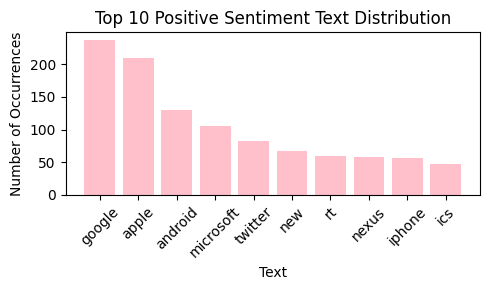

In [28]:
plot_top_words_distribution(Sanders, 'tweet', 'label', top_n=10, color='pink', title='Top 10 Positive Sentiment Text Distribution', xaxis_text='Text', yaxis_text='Number of Occurrences')

#### OMD Top 10 Tokens:

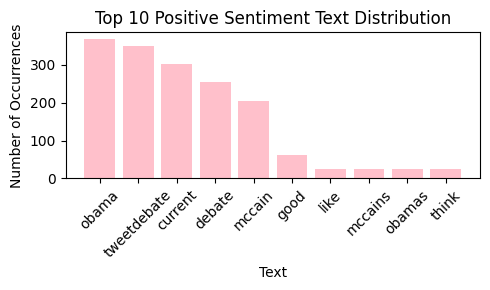

In [29]:
plot_top_words_distribution(OMD, 'tweet', 'label', top_n=10, color='pink', title='Top 10 Positive Sentiment Text Distribution', xaxis_text='Text', yaxis_text='Number of Occurrences')

Now it's time for **Stemming** and **Lemmatization**.\
Stemming means to cut off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word.\
Lemization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language.\
I used lemmatization here.

In [30]:
def lemmatization(tweet):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemmatize_words = np.vectorize(wordnet_lemmatizer.lemmatize)
    lemmatized_array = lemmatize_words(tweet)
    
    return lemmatized_array

In [31]:
Sanders['tweet']=Sanders['tweet'].apply(lambda X: lemmatization(X))
Sanders.head()

,label,tweet
0,0,"[rt, cjwallace, apparently, apple, put, mb, ca..."
1,0,"[rt, jewelz, mashable, apple, iphones, r, expe..."
2,0,"[mashable, apple, iphones, r, expensive, went,..."
3,0,"[kill, apple, httptcojwzc, rip, apple]"
4,4,"[apple, get, swype, iphone, crack, iphone]"


In [32]:
OMD['tweet']=OMD['tweet'].apply(lambda X: lemmatization(X))
OMD.head()

,tweet,label
0,"[watching, tweetdebate, drinking, waiting, sta...",0
1,"[ahg, michdot, yeah, slime, actually, second, ...",0
2,"[preparing, heart, attack, tweetdebate]",0
3,"[debate, moderator, sorry, tweetdebate]",0
4,"[current, staring, black, screen, httpwwwcurre...",0


#### TFIDF vectorication:
As you can see tweet column includes array. I first have to convert it to string.

In [33]:
def string_maker(tweet):
    new = ' '.join(tweet)
    return new

In [34]:
Sanders['tweet']=Sanders['tweet'].apply(lambda X: string_maker(X))
Sanders.head()

,label,tweet
0,0,rt cjwallace apparently apple put mb cap sm ne...
1,0,rt jewelz mashable apple iphones r expensive w...
2,0,mashable apple iphones r expensive went w htcg...
3,0,kill apple httptcojwzc rip apple
4,4,apple get swype iphone crack iphone


In [35]:
OMD['tweet']=OMD['tweet'].apply(lambda X: string_maker(X))
OMD.head()

,tweet,label
0,watching tweetdebate drinking waiting start cr...,0
1,ahg michdot yeah slime actually second choice ...,0
2,preparing heart attack tweetdebate,0
3,debate moderator sorry tweetdebate,0
4,current staring black screen httpwwwcurrentcom...,0


Now I can do tfidf vectorization.

In [36]:
vectorizer = TfidfVectorizer()
X_1 = vectorizer.fit_transform(Sanders['tweet'])
y_1 = Sanders['label']

In [37]:
vectorizer = TfidfVectorizer()
X= vectorizer.fit_transform(OMD['tweet'])
y = OMD['label']

### Training Models:


#### Naive Bayes Function:

In [38]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def train_multinomial_naive_bayes_classifier(X, y, n_splits, test_size, random_state):
    # Initialize a Multinomial Naive Bayes classifier
    clf = MultinomialNB()

    # Initialize a ShuffleSplit cross-validation object
    cross_validation = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = clf.predict(X_train)
    train_accuracy_NB = accuracy_score(y_train, y_train_pred)

    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)
    test_accuracy_NB = accuracy_score(y_test, y_test_pred)

    # Use cross-validation to calculate the mean accuracy
    cross_val_scores = cross_val_score(clf, X, y, cv=cross_validation)
    cross_val_accuracy_NB = cross_val_scores.mean()
    
    cm = confusion_matrix(y_test, y_test_pred)
    
    return train_accuracy_NB * 100,  test_accuracy_NB * 100, cross_val_accuracy_NB * 100, cm



#### Logistic Regression Function

In [39]:

def train_logistic_regression_classifier(X, y, max_iter, random_state, n_splits, test_size):
    # Initialize a Logistic Regression model
    clf_lr = LogisticRegression(max_iter=max_iter, random_state=random_state)

    cross_validation = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    clf_lr.fit(X_train, y_train)

    y_train_pred = clf_lr.predict(X_train)
    train_accuracy_LR = accuracy_score(y_train, y_train_pred)

    y_test_pred = clf_lr.predict(X_test)
    test_accuracy_LR = accuracy_score(y_test, y_test_pred)

    # Use cross-validation to calculate the mean accuracy
    cross_val_scores = cross_val_score(clf_lr, X, y, cv=cross_validation)
    cross_val_accuracy_LR = cross_val_scores.mean()
    
    cm = confusion_matrix(y_test, y_test_pred)
    
    return train_accuracy_LR * 100, test_accuracy_LR * 100, cross_val_accuracy_LR * 100, cm


#### Random Forest Function:

In [40]:

def train_random_forest_classifier(X, y, n_splits, random_state, n_estimators, max_depth, min_samples_leaf, test_size):
    # Initialize a Random Forest model
    clf_rf = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    cross_validation = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    clf_rf.fit(X_train, y_train)

    y_train_pred = clf_rf.predict(X_train)
    train_accuracy_RF = accuracy_score(y_train, y_train_pred)

    y_test_pred = clf_rf.predict(X_test)
    test_accuracy_RF = accuracy_score(y_test, y_test_pred)

    # Use cross-validation to calculate the mean accuracy
    cross_val_scores = cross_val_score(clf_rf, X, y, cv=cross_validation)
    cross_val_accuracy_RF = cross_val_scores.mean()
    
    cm = confusion_matrix(y_test, y_test_pred)
    
    return train_accuracy_RF * 100, test_accuracy_RF * 100,  cross_val_accuracy_RF * 100, cm

#### Function to Plot Results:

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(models, train_scores, cross_val_scores, test_scores, colors=None):
    if colors is None:
        # Default colors
        colors = ['#ADD8E6', '#D3D3D3', '#FFC0CB']  # Light blue, light grey, light pink
    
    # Bar chart
    bar_width = 0.2  # Adjusted bar width
    index = np.arange(len(models))

    plt.figure(figsize=(8, 4))
    plt.bar(index - bar_width, train_scores, bar_width, label='Train accuracy', color=colors[0], alpha=0.7)
    plt.bar(index, cross_val_scores, bar_width, label='Cross-Val score', color=colors[1], alpha=0.7)
    plt.bar(index + bar_width, test_scores, bar_width, label='Test accuracy', color=colors[2], alpha=0.7)

    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Comparison - Training, Cross-Validation Score, and Test Accuracy')
    plt.xticks(index, models)
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


#### Naive Bayes Results:

Sanders:

In [42]:
train_accuracy_NB, test_accuracy_NB, cross_val_accuracy_NB, cm = train_multinomial_naive_bayes_classifier(X_1, y_1, n_splits=10, test_size=0.27, random_state=0)

print('Training Accuracy:', train_accuracy_NB)
print('Test Accuracy:', test_accuracy_NB)
print('Cross-Validation Accuracy:', cross_val_accuracy_NB)
print("\n")

print('confusion matrix:')
print(cm)

Training Accuracy: 96.8335035750766
Test Accuracy: 84.89795918367346
Cross-Validation Accuracy: 82.47734138972808


confusion matrix:
[[114  17]
 [ 20  94]]


OMD:

In [43]:
train_accuracy_NB, test_accuracy_NB, cross_val_accuracy_NB, cm = train_multinomial_naive_bayes_classifier(X, y, n_splits=10, test_size=0.27, random_state=0)

print('Training Accuracy:', train_accuracy_NB)
print('Test Accuracy:', test_accuracy_NB)
print('Cross-Validation Accuracy:', cross_val_accuracy_NB)
print("\n")

print('confusion matrix:')
print(cm)

Training Accuracy: 90.41994750656168
Test Accuracy: 76.43979057591623
Cross-Validation Accuracy: 72.29126213592232


confusion matrix:
[[240  13]
 [ 77  52]]


---------------------------------------------------------------
---------------------------------------------------------------
---------------------------------------------------------------

#### Logistic Regression Results:

Sanders:

In [44]:
train_accuracy_LR, test_accuracy_LR, cross_val_accuracy_LR, cm = train_logistic_regression_classifier(X_1, y_1, max_iter=1000, random_state=42, n_splits=10, test_size=0.27)

print('Training Accuracy:', train_accuracy_LR)
print('Test Accuracy:', test_accuracy_LR)
print('Cross-Validation Accuracy:', cross_val_accuracy_LR)
print("\n")

print('confusion matrix:')
print(cm)

Training Accuracy: 94.58631256384066
Test Accuracy: 80.40816326530611
Cross-Validation Accuracy: 79.54682779456192


confusion matrix:
[[111  12]
 [ 36  86]]


OMD:

In [45]:
train_accuracy_LR, test_accuracy_LR, cross_val_accuracy_LR, cm = train_logistic_regression_classifier(X, y, max_iter=1000, random_state=42, n_splits=10, test_size=0.27)
print('Training Accuracy:', train_accuracy_LR)
print('Test Accuracy:', test_accuracy_LR)
print('Cross-Validation Accuracy:', cross_val_accuracy_LR)
print("\n")

print('confusion matrix:')
print(cm)

Training Accuracy: 85.69553805774278
Test Accuracy: 73.82198952879581
Cross-Validation Accuracy: 76.11650485436893


confusion matrix:
[[213  16]
 [ 84  69]]


---------------------------------------------------------------
---------------------------------------------------------------
---------------------------------------------------------------

#### Random Forest Results:
Sanders:

In [46]:
train_accuracy_RF, test_accuracy_RF, cross_val_accuracy_RF, cm =  train_random_forest_classifier(X_1, y_1, n_splits=10, random_state=30, n_estimators=1000, max_depth=50, min_samples_leaf=2, test_size=0.27)

print('Training Accuracy:', train_accuracy_RF)
print('Test Accuracy:', test_accuracy_RF)
print('Cross-Validation Accuracy:', cross_val_accuracy_RF)
print("\n")

print('confusion matrix:')
print(cm)

Training Accuracy: 89.27477017364657
Test Accuracy: 79.59183673469387
Cross-Validation Accuracy: 77.82477341389729


confusion matrix:
[[111  14]
 [ 36  84]]


OMD:

In [47]:
train_accuracy_RF, test_accuracy_RF, cross_val_accuracy_RF, cm =  train_random_forest_classifier(X, y, n_splits=10, random_state=30, n_estimators=1000, max_depth=50, min_samples_leaf=2, test_size=0.27)
print('Training Accuracy:', train_accuracy_RF)
print('Test Accuracy:', test_accuracy_RF)
print('Cross-Validation Accuracy:', cross_val_accuracy_RF)
print("\n")

print('confusion matrix:')
print(cm)

Training Accuracy: 84.97375328083989
Test Accuracy: 72.5130890052356
Cross-Validation Accuracy: 74.6019417475728


confusion matrix:
[[213  18]
 [ 87  64]]


### Ploting Results:
#### Sanders:

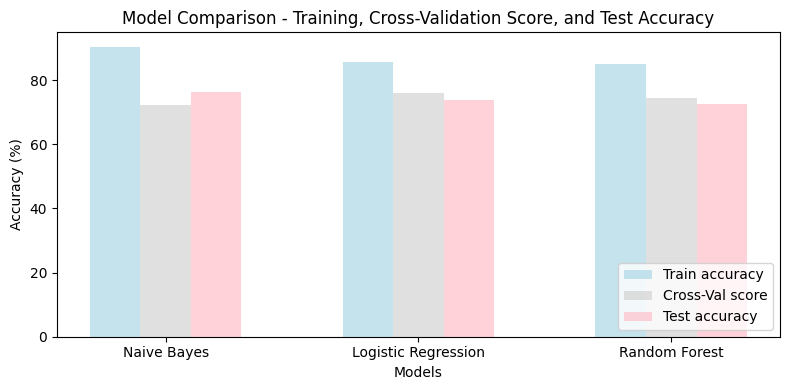

In [48]:
# Accuracy scores for each model and dataset
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
train_scores = [train_accuracy_NB , train_accuracy_LR , train_accuracy_RF ]
cross_val_scores = [cross_val_accuracy_NB , cross_val_accuracy_LR , cross_val_accuracy_RF ]
test_scores = [test_accuracy_NB , test_accuracy_LR , test_accuracy_RF ]

# Define custom colors
colors = ['#ADD8E6', '#D3D3D3', '#FFC0CB']  # Light blue, light grey, light pink


plot_model_comparison(models, train_scores, cross_val_scores, test_scores, colors=None)


#### OMD:

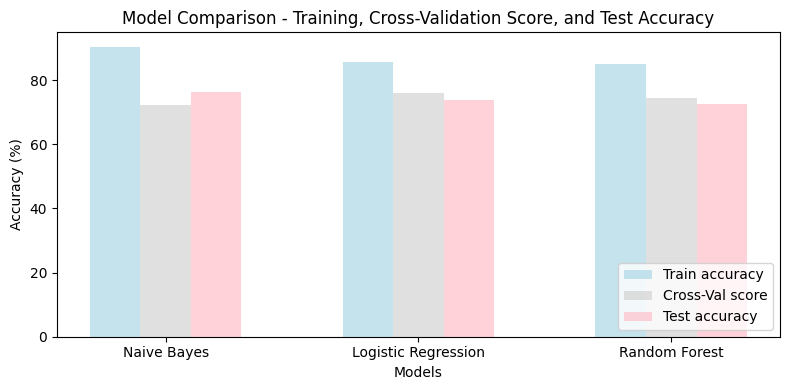

In [49]:
# Accuracy scores for each model and dataset
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
train_scores = [train_accuracy_NB , train_accuracy_LR , train_accuracy_RF ]
cross_val_scores = [cross_val_accuracy_NB , cross_val_accuracy_LR , cross_val_accuracy_RF ]
test_scores = [test_accuracy_NB , test_accuracy_LR , test_accuracy_RF ]

# Define custom colors
colors = ['#ADD8E6', '#D3D3D3', '#FFC0CB']  # Light blue, light grey, light pink


plot_model_comparison(models, train_scores, cross_val_scores, test_scores, colors=None)